# Autoregressive Neural Networks

In this tutorial we will use autoregressive approaches for virtual sensors to calculate the system response of a nonlinear System with external forcing. The tutorial provides an introduction to virtual sensors for dynamic systems. This tutorial defines a starting point introducing the main concepts of autoregressive neural networks and the usage inside the softsensor package. 


## Database
As part of Data Science, Deep Learning methods learn from an existing data set. The goal is to learn the principal dynamics behind the duffing oscillation. For the first use case, data is therefore generated from the differential equation using numerical integration. 
<br>
The Duffing equation is a nonlinear second-order differential equation used to model certain damped and driven oscillators. It is expressed as:

$$
\ddot{x} + D\dot{x} + x + c_{\text{nlin}}x^3 = F(t)
$$
Where:
- $x$ is the displacement,
- $D$ is the damping coefficient,
- $c_{\text{nlin}}$ is the nonlinear stiffness coefficient,
- $F(t)$ is the external forcing function.

<br>
A data set must be generated for the training process as well as another one for the later evaluation. In the present case, exchange signals are used as excitation in both the training and the evaluation.


In [1]:
from softsensor.data_gen import white_noise, get_academic_data
import numpy as np
# Duffing Parameters
params = {'D': 0.05,
          'c_nlin': 0.1}

model = 'Duffing'

fs = 10 # sampling rate
end_t = 100 # time period of the training data time series
n_ts = 50 # number of time series


# generate training data
time = np.linspace(0, end_t, end_t*fs+1)
F = [white_noise(time) for _ in range(n_ts)]

training_data = []
for f in F:
    temp_df = get_academic_data(time, model, params, f, x0=[0, 0], rtol=1e-10)
    training_data.append(temp_df)

train_names = [f'White Noise {f}' for f in range(n_ts)]

## Plot the Data
Before we start with the actual preprocessing we want to plot the given data to get a feeling for the properties. 
For convenience, we just plot the first entry of our list of DataFrames.

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

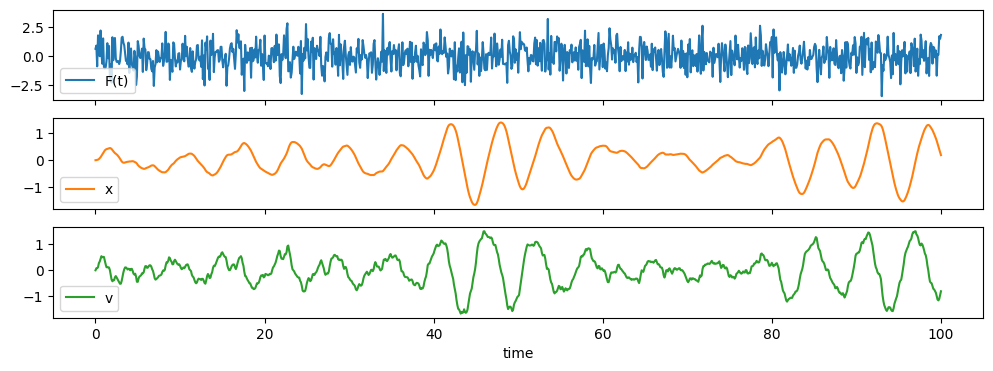

In [2]:
training_data[0].plot(subplots=True, sharex=True, figsize=(12,4))

## Data Preprocessing

For many machine learning models, preprocessing is necessary. Our toolbox uses the class `Meas_handling` for the entire preprocessing. `Meas_handling` can used to transform or scale the data into a normally distributed range. Furthermore, the entire frequency range is not relevant for our analysis. Therefore, we filter between 0,2 Hz to 4 Hz.

Furthermore, we split the data in training and evaluation data. We use the first two Measurments as training and the last one as evaluation.

Lastly we need to define what will be the inputs and output of our model. For the Duffing oscillation we aim at predicting the response $x(t)$ given the external excitaion $F(t)$

In [3]:
from softsensor.meas_handling import Meas_handling
from sklearn.preprocessing import StandardScaler
input = ['F(t)']
output = ['x']
data_handle = Meas_handling(training_data[:40], train_names[:40], input, output, fs,
                            training_data[40:], train_names[40:])

freq_lim = (.2, 4)
data_handle.Filter(freq_lim)
data_handle.Scale(StandardScaler())

## Define linear Models
We define two different benchmark Models in our example. 
First we define an Autoregressive Model with exogenious input (ARX) to approximate the functional dependency between input and output as linear combinations. The model is autoregressive as it feeds back in the past outputs into the equation, leading to:

$y_i(t+1) = \mathbf{a} \cdot \mathbf{x}_i(t, ..., t-o_x) + \mathbf{b} \cdot \mathbf{y}_i(t, ..., t-o_y))$

where $\mathbf{a}$ and $\mathbf{b}$ define the different weights for each input as linear combinations, t the time step and $o_x, o_y$ the number of past time steps to include in the computation.

We define our ARX model with order = [10, 10] leading to the past 10 time steps of input and output to be included in the computation. The `ARX.fit` function takes a list of `pandas.DataFrames` as well as the input aud output sensor names as input. We can access the `pandas.DataFrames` in our `data_handle` by simply using the internal variable `train_df` which returns a list of DataFrames for training. (`test_df` would return a list of DataFrames for testing)

In [4]:
from softsensor.arx import ARX
arx = ARX(order=[2, 2])
arx.fit(data_handle.train_df, input, output)

$\textbf{Congratulation!!!}$ You now have developed your first virtual sensor for acceleration Measurements

The ARX is a purely time domain model and is used in a multitude of use cases with different signal types. Since our datasets are acceleration measurements, we define a second linear approach in the frequency domain, namely the linear Transfer function.

Setting up the model is quite simple as is takes no input variables. The linear_TF fit function takes a list of `pandas.DataFrames` as well as the input aud output sensor names as input. Furthermore, we need to define a window size and sampling rate for the Fourier transformation conducted in out model. 

In [5]:
from softsensor.linear_methods import tf
tf_class = tf(window_size=128, hop=64, fs=10)
tf_class.fit(data_handle.train_df, input, output)

$\textbf{Congratulation!!!}$ You now have developted your second virtual sensor for acceleration Measurments

## Model Evaluation
To Evaluate our model on testing data we use the predefined functions `comp_pred`, which computes the prediction for a defined track in the data_handle class. As track we choose our testing track, which can be accessed using the internal variable `test_names`. Furthermore we compute

<Axes: xlabel='time'>

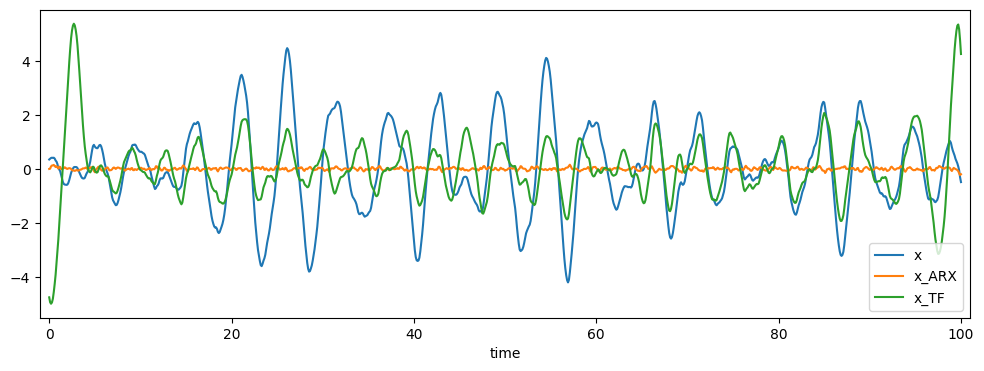

In [6]:
from softsensor.eval_tools import comp_pred
track = data_handle.test_names[0]
models = [arx, tf_class]
pred_df = comp_pred(models, data_handle, track)
pred_df.filter(regex='x').plot(figsize=(12,4))


The evaluation of the ARX and linear Transfer Function models shows that both models deliver very poor performance in predicting the system response.

## Define ARNN Model
We define an Autoregressive Neural Network (ARNN) to approximate the functional dependency between input and output as linear combinations. The model is autoregressive as it feeds back in the past outputs into the equation, leading to:

$y_i(t+1) = f \bigl( \mathbf{x}_i(t, ..., t-w_x), \mathbf{y}_i(t-1, ..., t-w_y-1) \bigr)$

Formally this model is called NARX (nonlinear autoregressive model with exogenious input) and takes:
 * number of input channels (`input_channels`)
 * number of output channels (`pred_size`)
 * window size $w_x$ (`window_size`)
 * recurrent window size $w_y$ (`rnn_window`)
 * neurons in the hidden layers (`hidden_size`)
 * activation function (`activation`)
 
as input

In [7]:
from softsensor.autoreg_models import ARNN
from torchinfo import summary

ARNN = ARNN(input_channels=len(input), pred_size=len(output), window_size=10, rnn_window=10,
            hidden_size=[32, 16], activation='leaky_relu')
summary(ARNN)

Layer (type:depth-idx)                   Param #
ARNN                                     --
├─Feed_ForwardNN: 1-1                    --
│    └─Sequential: 2-1                   --
│    │    └─Linear: 3-1                  672
│    │    └─LeakyReLU: 3-2               --
│    │    └─Linear: 3-3                  528
│    │    └─LeakyReLU: 3-4               --
│    │    └─Linear: 3-5                  17
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0

After we have defined the model, the next step is to adapt the model to the data. The training and validation data can be extracted from the predefined `data_handle` class and then trained using the `train_model` function. The method needs as input.

* `window_size`: defines the length of the time window, needs to be the same as for the model
* `rnn_window`: defines the length of the recurrent time window, needs to be the same as for the model
* `keyword`: either `training` or `short`, training uses the whole training dataset, while short uses only a small subset

In [8]:
from softsensor.train_model import train_model
import torch.optim as optim
import torch.nn as nn

train_loader, val_loader = data_handle.give_torch_loader(window_size=ARNN.window_size,
                                                         rnn_window=ARNN.rnn_window, 
                                                         keyword='training')

Furthermore, some training parameters are needed, which have to be passed to the class `train_model`:

* `model`: ARNN to be trained
*  `train_loader`: training data
* `max_epochs`: maximum number of epochs for training
* `optimizer`: optimizer used  for optimization, check [Link](https://pytorch.org/docs/stable/optim.html) for different possible optimizers
* `device`: device for training
* `criterion`: loss function to train against check [Link](https://pytorch.org/docs/stable/nn.html#loss-functions) for possible criterions
* `stabelizer`: stability parameter\* that is important to get a stable prediction after training. For theory about stability criterion read: [Westmeier et al.](https://onlinelibrary.wiley.com/doi/10.1002/pamm.202200318)
* `val_loader`: validation data
* `patience`: number of epochs without improvement to stop training process
* `print_results`: if True, results are printed

\* The stability parameter defines a relative weight between the actual loss function and a local weight decay. The corresponding stability score (SC) will be printed during training and, if below zero, ensures a stable prediction under all circumstances, however in a lot of cases a SC above zero might also be ok. For more on this read [Westmeier et al.](https://onlinelibrary.wiley.com/doi/10.1002/pamm.202200318)

In [9]:
opt = optim.Adam(ARNN.parameters(), lr=1e-4)
crit = nn.MSELoss()
results = train_model(model=ARNN, train_loader=train_loader, max_epochs=30, optimizer=opt, device='cpu', criterion=crit,
                     stabelizer=5e-3, val_loader=val_loader, patience=3, print_results=True)

$\textbf{Congratulation!!!}$ you have successfully fitted an autoregressive neural network to the training data

<Axes: xlabel='time'>

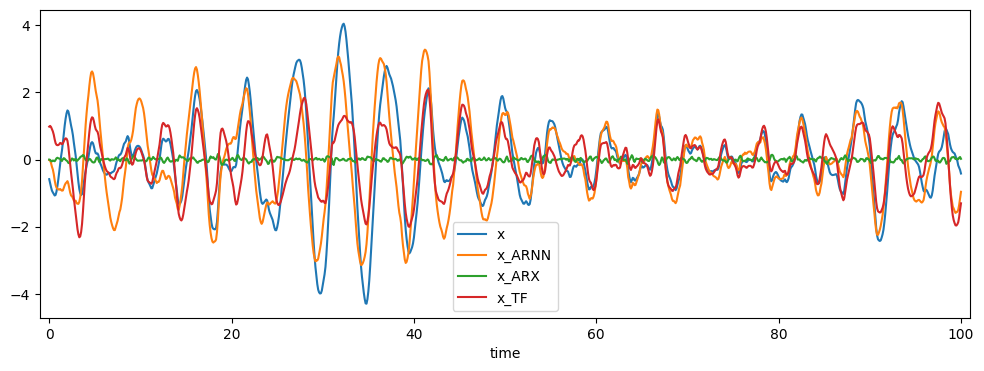

In [10]:
track = data_handle.test_names[1]
models = [ARNN, arx, tf_class]

pred_df = comp_pred(models, data_handle, track, names=['ARNN', 'ARX', 'TF'])
pred_df.filter(regex='x').plot(figsize=(12,4))

<Axes: >

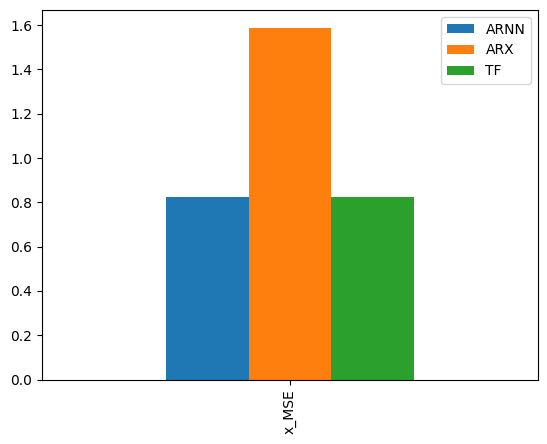

In [11]:
from softsensor.eval_tools import comp_error
error = comp_error(pred_df, output, fs, names=['ARNN', 'ARX', 'TF'], metrics=['MSE'])
error.filter(regex='MSE', axis=0).plot.bar()